# Clustering HCA Mouse Atlas with scVI and ScanPy

Disclaimer: some of the code in this notebook was taken from Scanpy's Clustering tutorial (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) which is itself based on SEURAT's clustering tutorial in R.

This notebook is designed as a demonstration of scVI's potency on the tasks considered in the Scanpy PBMC 3K Clustering notebook.
In order to do so, we follow the same workflow adopted by scanpy in their clustering tutorial while performing the analysis using scVI as often as possible.
Specifically, we use scVI's latent representation and differential expression analysis (which computes a Bayes Factor on imputed values). 
For visualisation, pre-processing and for some canonical analysis, we use the Scanpy package directly.

When useful, we provide high-level wrappers around scVI's analysis tools. These functions are designed to make standard use of scVI as easy as possible.
For specific use cases, we encourage the reader to take a closer look at those functions and modify them according to his needs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../../

/nfs/team205/zx3/PycharmProject/scVI


In [3]:
n_epochs_all = None
save_path = 'data/'
show_plot = True

# Setup before running the notebook


In [4]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import louvain

use_cuda = True
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE


from umap import UMAP

[2019-09-16 10:32:59,684] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/nfs/team205/zx3/.venv/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [5]:
from scvi.dataset import DownloadableRawAnnDataset

In [12]:
import torch
torch.cuda.set_device(7)
print(torch.cuda.current_device())

7


# scVI (single-cell Variational Inference)

___scVI___ is a hierarchical Bayesian model for single-cell RNA sequencing data with conditional distributions parametrized by neural networks. Working as a hybrid between a neural network and a bayesian network, scVI performs data harmonization. VAE refers to variational auto-encoders for single-cell gene expression data. scVI is similar to VAE as it tries to bring a more suitable structure to the latent space. While VAE allows users to make observations in a semi-supervised fashion, scVI is easier to train and specific cell-type labels for the dataset are not required in the pure unsupervised case.

In [7]:
import scanpy as sc


In [7]:
DATAFILE = '../data/'
save_path = DATAFILE+"MouseAtlas.total.h5ad"


In [10]:
DATAFILE = "/lustre/scratch117/cellgen/team205/tpcg/backup/backup_20190401/sc_sclassification/CellTypist/data_repo/MouseAtlas/"
save_path = DATAFILE+"MouseAtlas.total.h5ad"


In [9]:
adata_mouse = sc.read_h5ad(save_path)
adata_mouse.raw.X.shape 

In [11]:
scviDataset = DownloadableRawAnnDataset("MouseAtlas.total.h5ad", save_path=DATAFILE)

[2019-09-16 10:36:26,266] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-09-16 10:36:26,276] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-09-16 10:36:28,027] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-16 10:36:31,203] INFO - scvi.dataset.dataset | Downsampled from 267690 to 267690 cells
[2019-09-16 10:37:09,093] INFO - scvi.dataset.dataset | Downsampling from 37878 to 10000 genes
[2019-09-16 10:37:13,113] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-16 10:37:14,708] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-09-16 10:37:16,368] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-09-16 10:37:17,975] INFO - scvi.dataset.dataset | Downsampled from 267690 to 267690 cells


In [13]:
scviDataset

GeneExpressionDataset object with n_cells x nb_genes = 267690 x 10000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'local_vars', 'labels', 'local_means'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

## Define the scVI model

In [14]:
from scvi.inference import UnsupervisedTrainer, Posterior
from scvi.models.vae import VAE
from typing import Tuple

In [17]:
def compute_scvi_latent(
    scviDataset: GeneExpressionDataset,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    # scviDataset = AnnDataset(adata)

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent=n_latent,
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=0.8, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent

## Train the vae model for 50 epochs 

In [18]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all

scvi_posterior, scvi_latent = compute_scvi_latent(
    scviDataset, n_epochs=n_epochs, n_latent=6, use_cuda = True
)


training: 100%|██████████| 50/50 [22:21<00:00, 26.83s/it]


In [20]:
adata_mouse.obsm["X_scvi"] = scvi_latent

### Use the saved model to ensure that the down stream analysis cluster id are identical, but the result is robust to reruns of the model, although the exact numerical ids of the clusters might change

In [19]:
model = scvi_posterior.model
torch.save(model.state_dict(),'saved_model/notebook/'+'mouse.atlas.model.scvi_16092019.pkl')

### And load the trained weights using load_state_dict

In [ ]:
trainer.model.load_state_dict(torch.load("saved_model/notebook/"+'mouse.atlas.model.scvi.pkl'))

# Visualize the latent space

### Use UMAP to generate 2D visualization¶

In [23]:
latent_u = UMAP(spread=2).fit_transform(scvi_latent)

/nfs/team205/zx3/.venv/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.venv/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/nfs/team205/zx3/.venv/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.venv/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.n

### Plot data colored by dataset

In [24]:
%matplotlib inline

In [27]:
Dataset = scviDataset.obs["Dataset"]
np.unique(Dataset)

array(['Brain', 'Embryo', 'Gastrula', 'HSC', 'Kidney', 'MCA',
       'Tabula(Droplet)', 'Tabula(Plate)', 'Thymus'], dtype=object)

/nfs/team205/zx3/.venv/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


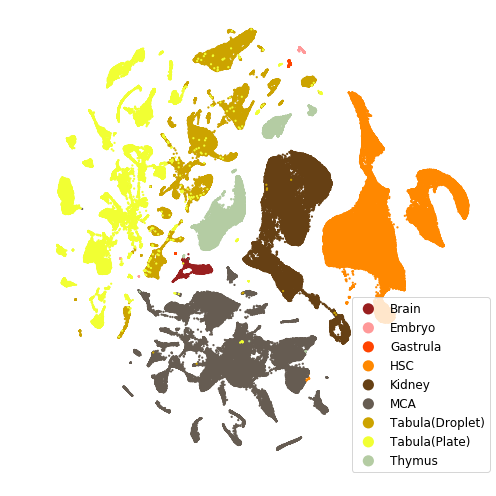

In [28]:
colors = ["#991f1f", "#ff9999", "#ff4400", "#ff8800", "#664014", "#665c52",
          "#cca300", "#f1ff33", "#b4cca3"]
fig = plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
for i, k in enumerate(np.unique(Dataset)):
    plt.scatter(latent_u[Dataset == k, 0], latent_u[Dataset == k, 1], label=k,
                edgecolors='none', c=colors[i], s=5)
    plt.legend(borderaxespad=0, fontsize='large', markerscale=5)

plt.axis('off')
fig.set_tight_layout(True)

## Principal component analysis to reproduce ScanPy results and compare them against scVI's

Below, we reproduce exactly scanpy's PCA on normalized data.

In [ ]:
sc.tl.pca(adata, svd_solver="arpack")

In [ ]:
sc.pl.pca(adata, color="CST3")

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

## Computing, embedding and clustering the neighborhood graph

The Scanpy API computes a neighborhood graph with `sc.pp.neighbors` which can be called to work on a specific representation `use_rep='your rep'`.
Once the neighbors graph has been computed, all Scanpy algorithms working on it can be called as usual (that is *louvain*, *paga*, *umap* ...)

### Using PCA representation (Scanpy tutorial)

In [29]:
sc.pp.neighbors(adata_mouse, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata_mouse, key_added="louvain_pca")
sc.tl.umap(adata_mouse)

/nfs/team205/zx3/.venv/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.venv/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/nfs/team205/zx3/.venv/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.venv/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    

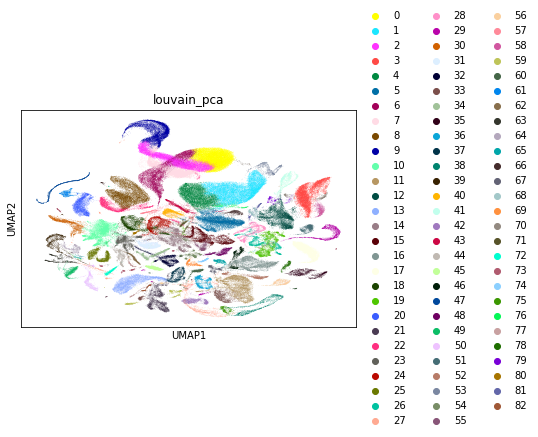

In [32]:
sc.pl.umap(adata_mouse, color=["louvain_pca"])

### Using scVI latent space representation

In [34]:
sc.pp.neighbors(adata_mouse, n_neighbors=20, n_pcs=40, use_rep="X_scvi")
sc.tl.umap(adata_mouse)

/nfs/team205/zx3/.venv/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.venv/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [35]:
sc.tl.louvain(adata_mouse, key_added="louvain_scvi", resolution=0.7)

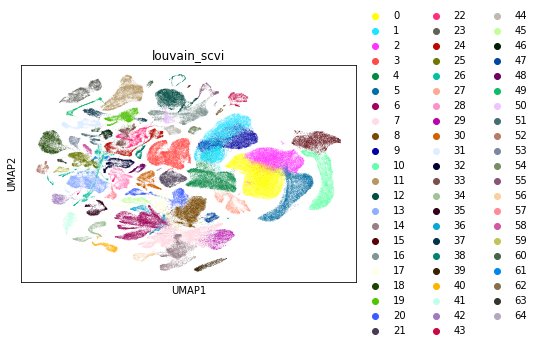

In [36]:
sc.pl.umap(adata_mouse, color=["louvain_scvi"])

# BBKNN Implimentation

In [ ]:
sc.tl.pca(adata_mouse)

In [ ]:
adata_mouse.X.shape

In [ ]:
adata_mouse.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata_mouse, log=True)

In [ ]:
import bbknn

In [ ]:
num_pcs = 21

# sc.pp.neighbors(adata_mouse,n_pcs=num_pcs, n_neighbors=20)
adata_bbknn = bbknn.bbknn(adata_mouse, n_pcs=num_pcs, copy=True, batch_key='Dataset')
sc.tl.umap(adata_bbknn)
sc.tl.louvain(adata_bbknn)


In [ ]:
sc.pl.umap(adata_bbknn, color=['Dataset','louvain'])